## Amazon Reviews - Sentiment Analysis usin NLP

Analyzing sentiments related to an Amazon product can be fun and difficult especially since the data is collected across various demographics around the world. Analyzing these sentiments will not only help us serve the customers better but can also reveal lot of customer traits present/hidden in the reviews.

So the task of this dataset is to correctly classify customer reviews sentiment. Our goal is also to investigate which supervised machine learning methods are best suited to solve it.

In [1]:
#import all necessary libraries

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk import bigrams, trigrams
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
from nltk.corpus import stopwords
from textblob import Word, TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,mean_squared_error,mean_absolute_error,log_loss,accuracy_score,classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df = pd.read_csv("amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


## Data Wrangling/Cleaning

In [3]:
print(df.shape)

(4915, 12)


In [4]:
df.dtypes

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
day_diff            int64
helpful_yes         int64
total_vote          int64
dtype: object

In [5]:
df.isnull().sum()

reviewerID        0
asin              0
reviewerName      1
helpful           0
reviewText        1
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

In [6]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'])
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1970-01-01 00:00:01.406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1970-01-01 00:00:01.382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1970-01-01 00:00:01.356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1970-01-01 00:00:01.384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1970-01-01 00:00:01.373673600,2013-07-13,513,0,0


In [7]:
df["asin"].unique()

array(['B007WTAJTO'], dtype=object)

In [8]:
print(len(df["reviewerID"].unique()))

4915


In [9]:
print(min(df['reviewTime']))
print(max(df['reviewTime']))

2012-01-09 00:00:00
2014-12-07 00:00:00


In [10]:
df = df.drop(['unixReviewTime', 'reviewerName', 'asin', 'helpful'], axis=1)

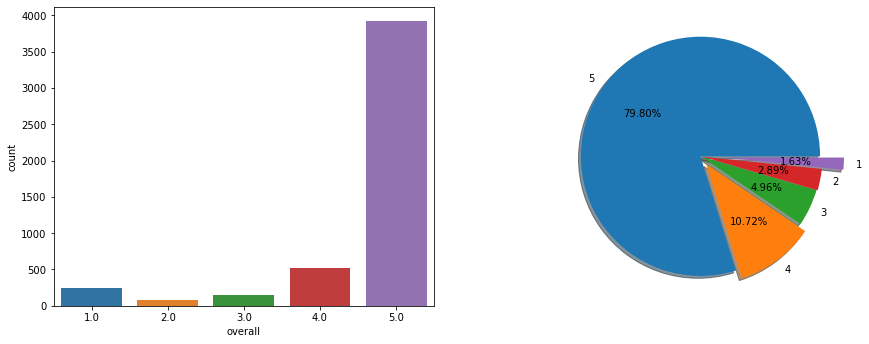

In [11]:
#df['overall'].value_counts().plot(kind="bar")
fig1, ax1 = plt.subplots(figsize=(15, 5.5))
#round(df['overall'].value_counts()/df.shape[0]*100).plot.pie(autopct='%1.1f') 

#plt.figure(figsize = (10, 5.5)
plt.subplot(1, 2, 1)
sns.countplot(x = df['overall'], data = df)

plt.subplot(1, 2, 2)
plt.pie(x= df['overall'].value_counts(),labels=('5','4','3','2','1') ,explode = (0, 0.08, 0.01,0.02,0.2), shadow = True, autopct = '%1.2f%%')

plt.show()

In [12]:
# Normalizing Case Folding
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [13]:
# Stopwords
sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [14]:
# Rarewords
drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [15]:
# Tokenization
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, sprung, higher, capacity, th...
3    [think, worked, greathad, diff, bran, gb, card...
4    [bought, retail, packaging, arrived, legit, or...
Name: reviewText, dtype: object

In [16]:
# Lemmatization 
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['reviewText'].head(10)

0                                                issue
1    purchased device worked advertised never much ...
2    work expected sprung higher capacity think mad...
3    think worked greathad diff bran gb card went s...
4    bought retail packaging arrived legit orange e...
5    mini storage doesnt anything else supposed pur...
6    phone never skip beat file transfer speedy cor...
7    hard believe affordable digital become gb devi...
8    work htc rezound running short space gb sandis...
9    galaxy super fast card totally happy happy sti...
Name: reviewText, dtype: object

In [17]:
# Calcuating the word counts
word_count = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
word_count.columns = ["words", "Count"]
word_count.head()

,words,Count
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00


In [18]:
word_count.shape

(8073, 2)

In [19]:
word_count["words"].nunique()

8073

In [20]:
word_count["Count"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count   8073.00
mean      15.33
std       96.17
min        1.00
5%         1.00
10%        1.00
25%        1.00
50%        1.00
75%        4.00
80%        7.00
90%       20.00
95%       53.00
99%      262.56
max     5537.00
Name: Count, dtype: float64

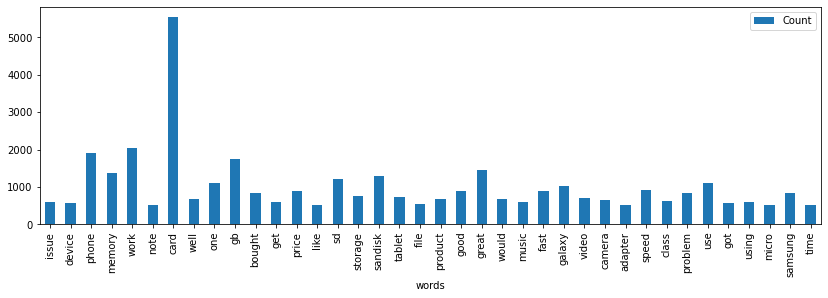

In [21]:
# Barplot
plt.rcParams["figure.figsize"] = (14, 4)
word_count[word_count["Count"] > 500].plot.bar(x="words", y="Count")
plt.show()

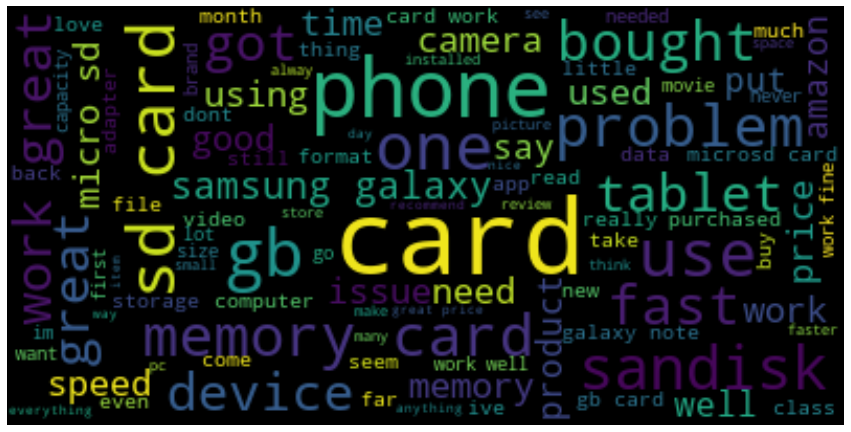

In [22]:
# Wordcloud
text = " ".join(i for i in df.reviewText)
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(text)
plt.figure( figsize=(15,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Exploratory Data Analysis

In [23]:
sia = SentimentIntensityAnalyzer()

In [24]:
# Use capital letter for reviews
df["reviewText"].apply(lambda x: x.upper())

0                                                   ISSUE
1       PURCHASED DEVICE WORKED ADVERTISED NEVER MUCH ...
2       WORK EXPECTED SPRUNG HIGHER CAPACITY THINK MAD...
3       THINK WORKED GREATHAD DIFF BRAN GB CARD WENT S...
4       BOUGHT RETAIL PACKAGING ARRIVED LEGIT ORANGE E...
                              ...                        
4910    BOUGHT SANDISK GB CLASS USE HTC INSPIRE MONTH ...
4911    USED EXTENDING CAPABILITY SAMSUNG GALAXY NOTE ...
4912    GREAT CARD FAST RELIABLE COME OPTIONAL ADAPTER...
4913           GOOD AMOUNT SPACE STUFF WANT FIT GOPRO SAY
4914    IVE HEARD BAD THING GB MICRO SD CARD CRAPPING ...
Name: reviewText, Length: 4915, dtype: object

In [25]:
#Character Count
df['char_count'] = df['reviewText'].str.len()
df[['reviewText','char_count']].head()

,reviewText,char_count
0,issue,5
1,purchased device worked advertised never much ...,91
2,work expected sprung higher capacity think mad...,93
3,think worked greathad diff bran gb card went s...,175
4,bought retail packaging arrived legit orange e...,217


In [26]:
#Avg word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/(len(words)+0.000001))

In [27]:
df['avg_word'] = df['reviewText'].apply(lambda x: avg_word(x)).round(1)
df[['reviewText','avg_word']].head()

,reviewText,avg_word
0,issue,5.00
1,purchased device worked advertised never much ...,6.10
2,work expected sprung higher capacity think mad...,5.70
3,think worked greathad diff bran gb card went s...,5.30
4,bought retail packaging arrived legit orange e...,5.40


In [28]:
# Polarity Scores for 10 reviews
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
3    {'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...
4    {'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.099, 'neu': 0.589, 'pos': 0.312, 'co...
7    {'neg': 0.066, 'neu': 0.703, 'pos': 0.231, 'co...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
Name: reviewText, dtype: object

In [29]:
# Choose one compound
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.90
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [30]:
#Create a Polarity score column
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,reviewerID,reviewText,overall,summary,reviewTime,day_diff,helpful_yes,total_vote,char_count,avg_word,polarity_score
0,A3SBTW3WS4IQSN,issue,4.00,Four Stars,2014-07-23,138,0,0,5,5.00,0.00
1,A18K1ODH1I2MVB,purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,2013-10-25,409,0,0,91,6.10,0.00
2,A2FII3I2MBMUIA,work expected sprung higher capacity think mad...,4.00,nothing to really say....,2012-12-23,715,0,0,93,5.70,0.40
3,A3H99DFEG68SR,think worked greathad diff bran gb card went s...,5.00,Great buy at this price!!! *** UPDATE,2013-11-21,382,0,0,175,5.30,0.65
4,A375ZM4U047O79,bought retail packaging arrived legit orange e...,5.00,best deal around,2013-07-13,513,0,0,217,5.40,0.86


In [31]:
# tagg the sentiments (neg/pos) and create sentiment column
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head()

,reviewerID,reviewText,overall,summary,reviewTime,day_diff,helpful_yes,total_vote,char_count,avg_word,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,issue,4.00,Four Stars,2014-07-23,138,0,0,5,5.00,0.00,neg
1,A18K1ODH1I2MVB,purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,2013-10-25,409,0,0,91,6.10,0.00,neg
2,A2FII3I2MBMUIA,work expected sprung higher capacity think mad...,4.00,nothing to really say....,2012-12-23,715,0,0,93,5.70,0.40,pos
3,A3H99DFEG68SR,think worked greathad diff bran gb card went s...,5.00,Great buy at this price!!! *** UPDATE,2013-11-21,382,0,0,175,5.30,0.65,pos
4,A375ZM4U047O79,bought retail packaging arrived legit orange e...,5.00,best deal around,2013-07-13,513,0,0,217,5.40,0.86,pos


In [32]:
# Check the balance of data
df["sentiment_label"].value_counts()

pos    3946
neg     969
Name: sentiment_label, dtype: int64

In [33]:
#sentiment label differences
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [34]:
# Encode the target variable
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])
df.head()

,reviewerID,reviewText,overall,summary,reviewTime,day_diff,helpful_yes,total_vote,char_count,avg_word,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,issue,4.00,Four Stars,2014-07-23,138,0,0,5,5.00,0.00,0
1,A18K1ODH1I2MVB,purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,2013-10-25,409,0,0,91,6.10,0.00,0
2,A2FII3I2MBMUIA,work expected sprung higher capacity think mad...,4.00,nothing to really say....,2012-12-23,715,0,0,93,5.70,0.40,1
3,A3H99DFEG68SR,think worked greathad diff bran gb card went s...,5.00,Great buy at this price!!! *** UPDATE,2013-11-21,382,0,0,175,5.30,0.65,1
4,A375ZM4U047O79,bought retail packaging arrived legit orange e...,5.00,best deal around,2013-07-13,513,0,0,217,5.40,0.86,1


## Data Split

In [35]:
X = df["reviewText"]
y = df["sentiment_label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, stratify=y, random_state = 44)

## Creating Pipelines

In [36]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier()),
               ])

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier()),
              ])

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C= 1, max_iter=500)),
               ])

In [39]:
from sklearn.svm import SVC

svc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel='linear', random_state = 10)),
               ])

In [40]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

# Modelling

In [41]:
# SGD Classifier (Stochastic Gradient Descent)
sgd.fit(X_train, y_train)

y_pred_sgd_train = sgd.predict(X_train)
y_pred_sgd_test = sgd.predict(X_test)

print(classification_report(y_train, y_pred_sgd_train))
print(classification_report(y_test, y_pred_sgd_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      3157

    accuracy                           1.00      3932
   macro avg       1.00      1.00      1.00      3932
weighted avg       1.00      1.00      1.00      3932

              precision    recall  f1-score   support

           0       0.75      0.39      0.52       194
           1       0.87      0.97      0.91       789

    accuracy                           0.85       983
   macro avg       0.81      0.68      0.71       983
weighted avg       0.84      0.85      0.84       983



In [42]:
#Random Forest
rf.fit(X_train, y_train)

y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

print(classification_report(y_train, y_pred_rf_train))
print(classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      3157

    accuracy                           1.00      3932
   macro avg       1.00      1.00      1.00      3932
weighted avg       1.00      1.00      1.00      3932

              precision    recall  f1-score   support

           0       0.79      0.15      0.26       194
           1       0.83      0.99      0.90       789

    accuracy                           0.83       983
   macro avg       0.81      0.57      0.58       983
weighted avg       0.82      0.83      0.77       983



In [43]:
# Logistic Regression
logreg.fit(X_train, y_train)

y_pred_log_train= logreg.predict(X_train)
y_pred_log_test = logreg.predict(X_test)

print(classification_report(y_train, y_pred_log_train))
print(classification_report(y_test, y_pred_log_test))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17       775
           1       0.82      1.00      0.90      3157

    accuracy                           0.82      3932
   macro avg       0.91      0.55      0.53      3932
weighted avg       0.85      0.82      0.75      3932

              precision    recall  f1-score   support

           0       0.92      0.06      0.11       194
           1       0.81      1.00      0.90       789

    accuracy                           0.81       983
   macro avg       0.86      0.53      0.50       983
weighted avg       0.83      0.81      0.74       983



In [44]:
#Support Vector Classifier
svc.fit(X_train, y_train)

y_pred_svc_train = svc.predict(X_train)
y_pred_svc = svc.predict(X_test)

print(classification_report(y_train, y_pred_svc_train))
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       775
           1       0.99      1.00      0.99      3157

    accuracy                           0.99      3932
   macro avg       0.99      0.97      0.98      3932
weighted avg       0.99      0.99      0.99      3932

              precision    recall  f1-score   support

           0       0.87      0.31      0.46       194
           1       0.85      0.99      0.92       789

    accuracy                           0.86       983
   macro avg       0.86      0.65      0.69       983
weighted avg       0.86      0.86      0.83       983



In [45]:
# Naive Bayes
nb.fit(X_train, y_train)

y_pred_nb_train = nb.predict(X_train)
y_pred_nb = nb.predict(X_test)

print(classification_report(y_train,y_pred_nb_train))
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       775
           1       0.80      1.00      0.89      3157

    accuracy                           0.80      3932
   macro avg       0.90      0.50      0.45      3932
weighted avg       0.84      0.80      0.72      3932

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.80      1.00      0.89       789

    accuracy                           0.80       983
   macro avg       0.40      0.50      0.45       983
weighted avg       0.64      0.80      0.71       983



## Model Performance Evaluation

Models will be evaluated by using Accuracy, Precision, Recall, F1 scores, and confusion matrix. Since the data has a significant imbalance issue towards positive reviews, precision score will be our main metric to evaluate the performance. 

## Model Metrics for SGD

In [48]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score, roc_auc_score

#train data
accuracy= accuracy_score(y_train, y_pred_sgd_train)
print('Accuracy for Train Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_train, y_pred_sgd_train)
print('Precision for Train Data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred_sgd_train)
print('Recall for Train Data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_train, y_pred_sgd_train)
print('F1 score for Train Data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_train, y_pred_sgd_train))

print('----------------------------------')

#test data
accuracy= accuracy_score(y_test, y_pred_sgd_test)
print('Accuracy for Test Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_test, y_pred_sgd_test)
print('Precision for Test Data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_sgd_test)
print('Recall for Test Data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred_sgd_test)
print('F1 score for Test Data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_test, y_pred_sgd_test))

Accuracy for Train Data: 0.999491
Precision for Train Data: 0.999683
Recall for Train Data: 0.999683
F1 score for Train Data: 0.999683
Roc-Auc: 0.9991964605025186
----------------------------------
Accuracy for Test Data: 0.854527
Precision for Test Data: 0.866213
Recall for Test Data: 0.968314
F1 score for Test Data: 0.914423
Roc-Auc: 0.6800334496230385


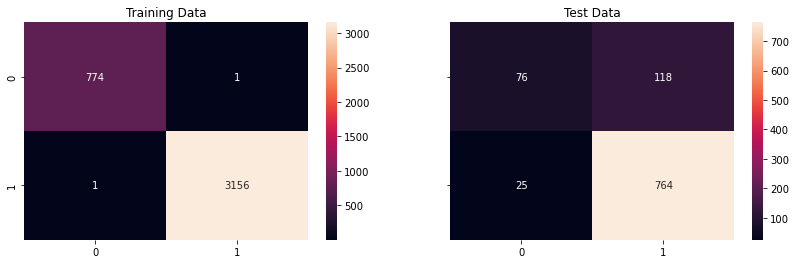

In [49]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Train and Test Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train, y_pred_sgd_train)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test, y_pred_sgd_test)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data');

## Model Metrics for Random Forest

In [51]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
#train data
accuracy= accuracy_score(y_train, y_pred_rf_train)
print('Accuracy for Test Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_train, y_pred_rf_train)
print('Precision for Train data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred_rf_train)
print('Recall for Train data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_train, y_pred_rf_train)
print('F1 score for Train data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_train, y_pred_rf_train))

print('----------------------------------')

#test data
accuracy= accuracy_score(y_test, y_pred_rf_test)
print('Accuracy for Test Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_test, y_pred_rf_test)
print('Precision for Test Data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_rf_test)
print('Recall for Test Data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred_rf_test)
print('F1 score for Test Data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_test, y_pred_rf_test))

Accuracy for Test Data: 1.000000
Precision for Train data: 1.000000
Recall for Train data: 1.000000
F1 score for Train data: 1.000000
Roc-Auc: 1.0
----------------------------------
Accuracy for Test Data: 0.825025
Precision for Test Data: 0.826455
Recall for Test Data: 0.989861
F1 score for Test Data: 0.900807
Roc-Auc: 0.5722498791371042


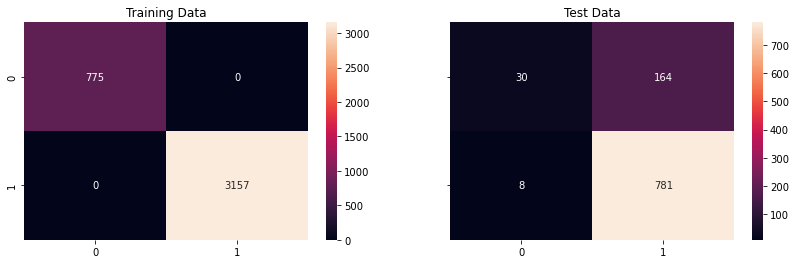

In [52]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,y_pred_rf_train)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,y_pred_rf_test)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data');

## Model Metrics for Logistic Regression

In [53]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score

#train data
accuracy= accuracy_score(y_train, y_pred_log_train)
print('Accuracy for Train Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_train, y_pred_log_train)
print('Precision for Train Data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred_log_train)
print('Recall for Train Data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_train, y_pred_log_train)
print('F1 score for Train Data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_train, y_pred_log_train))

print('----------------------------------')

#test data
accuracy= accuracy_score(y_test, y_pred_log_test)
print('Accuracy for Test Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_test, y_pred_log_test)
print('Precision for Test Data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_log_test)
print('Recall for Test Data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred_log_test)
print('F1 score for Test Data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_test, y_pred_log_test))

Accuracy for Train Data: 0.820702
Precision for Train Data: 0.817452
Recall for Train Data: 1.000000
F1 score for Train Data: 0.899558
Roc-Auc: 0.5451612903225806
----------------------------------
Accuracy for Test Data: 0.812818
Precision for Test Data: 0.811535
Recall for Test Data: 0.998733
F1 score for Test Data: 0.895455
Roc-Auc: 0.5277168019024473


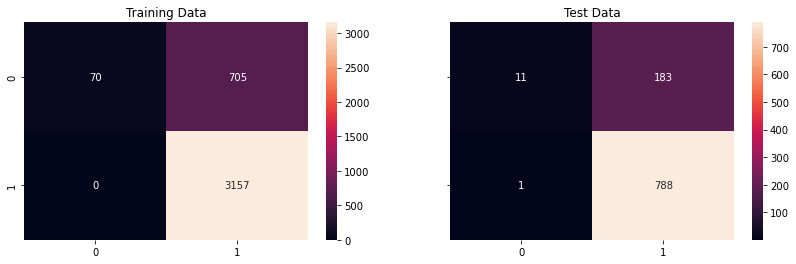

In [54]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train, y_pred_log_train)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test, y_pred_log_test)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data');

## Model Metrics for SVC

In [55]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score

#train data
accuracy= accuracy_score(y_train, y_pred_svc_train)
print('Accuracy for Train Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_train, y_pred_svc_train)
print('Precision for Train Data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred_svc_train)
print('Recall for Train Data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_train, y_pred_svc_train)
print('F1 score for Train Data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_train, y_pred_svc_train))

print('----------------------------------')

#test data
accuracy= accuracy_score(y_test, y_pred_svc)
print('Accuracy for Test Data: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_test, y_pred_svc)
print('Precision for Test Data: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_svc)
print('Recall for Test Data: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred_svc)
print('F1 score for Test Data: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', roc_auc_score(y_test, y_pred_svc))

Accuracy for Train Data: 0.988555
Precision for Train Data: 0.985946
Recall for Train Data: 1.000000
F1 score for Train Data: 0.992923
Roc-Auc: 0.9709677419354839
----------------------------------
Accuracy for Test Data: 0.855544
Precision for Test Data: 0.854326
Recall for Test Data: 0.988593
F1 score for Test Data: 0.916569
Roc-Auc: 0.6515130727921289


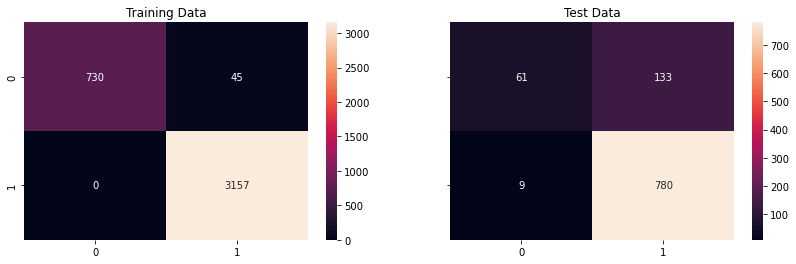

In [56]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train, y_pred_svc_train)),annot=True,fmt='.5g',ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test, y_pred_svc)),annot=True,fmt='.5g',ax=a[0][1]);
a[0][1].set_title('Test Data');

## Hyperparameter Optimization for SGD Classifier

In [57]:
#Hyperparameter Optimization for SGD Classifier
param_sgd = {
        "vect__max_df": (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000, 50000),
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "clf__alpha": (0.00001, 0.000001),
        "clf__penalty": ("l2", "elasticnet"),
        'clf__max_iter': (10, 50, 80),
    }
    
sgd1 = GridSearchCV(sgd, param_sgd, scoring='precision', n_jobs=-1, verbose=1)
    
print("performing grid search on SGD")
print("pipeline:", [name for name, _ in sgd.steps])
print("parameters:")
print(param_sgd)

#model fit 
sgd1.fit(X_train, y_train)
print()
    
print("Best score: %0.3f" % sgd1.best_score_)
print("Best parameters set:")
best_parameters = sgd1.best_estimator_.get_params()
for param_name in sorted(param_sgd.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

performing grid search on SGD
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet'), 'clf__max_iter': (10, 50, 80)}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best score: 0.894
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 50
	clf__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__max_features: 10000
	vect__ngram_range: (1, 1)


In [58]:
#Refit the model with tuned hyperparameters
sgd_final = Pipeline([('vect', CountVectorizer(max_df=1.0, max_features=10000, ngram_range=(1,1))),
                ('clf', SGDClassifier(alpha=1e-05, max_iter=50, penalty='elasticnet')),
               ])

best_model = sgd_final.fit(X_train, y_train)

y_pred_sgd_test = best_model.predict(X_test)

print(classification_report(y_test, y_pred_sgd_test))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       194
           1       0.92      0.92      0.92       789

    accuracy                           0.87       983
   macro avg       0.79      0.79      0.79       983
weighted avg       0.87      0.87      0.87       983



In [59]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
accuracy= accuracy_score(y_test, y_pred_sgd_test)
print('Accuracy: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_test, y_pred_sgd_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_sgd_test)
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred_sgd_test)
print('F1 score: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', metrics.roc_auc_score(y_test, y_pred_sgd_test))

Accuracy: 0.865717
Precision: 0.915297
Recall: 0.917617
F1 score: 0.916456
Roc-Auc: 0.7861282061333019


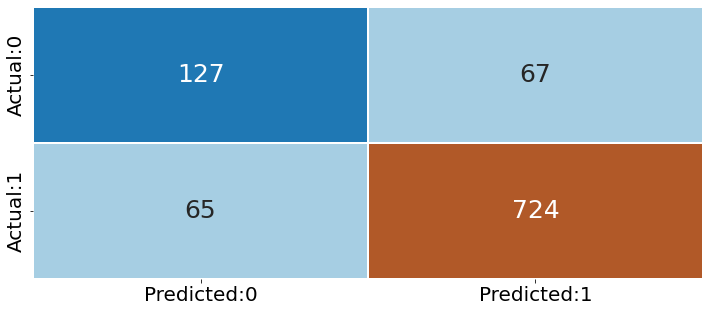

In [60]:
#defining the size of the canvas
plt.rcParams['figure.figsize'] = [12,5]
cm = confusion_matrix(y_test, y_pred_sgd_test)
#confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
#plotting the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

## Hyperparameter Tuning for Random Forest Model

In [61]:
# Hyperparameter Optimization for Random Forest Classsifier

rf_model = RandomForestClassifier(random_state=42)

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X_train)
X_count_test =vectorizer.transform(X_test)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [62]:
#let's see the best parameters 
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [63]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y_train)
rf_final_pred_test = rf_final.predict(X_count_test)

In [64]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
accuracy= accuracy_score(y_test, rf_final_pred_test)
print('Accuracy: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_test, rf_final_pred_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, rf_final_pred_test)
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, rf_final_pred_test)
print('F1 score: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', metrics.roc_auc_score(y_test, rf_final_pred_test))

Accuracy: 0.832146
Precision: 0.834764
Recall: 0.986058
F1 score: 0.904126
Roc-Auc: 0.5961219343289823


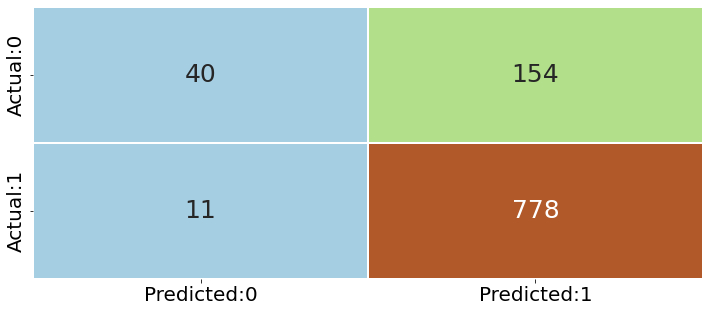

In [65]:
#defining the size of the canvas
plt.rcParams['figure.figsize'] = [12,5]
cm = confusion_matrix(y_test, rf_final_pred_test)
#confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
#plotting the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

## Hyperparameter Tuning for Logistic Regression

In [66]:
from sklearn.model_selection import GridSearchCV

grid=[{'clf__solver': ['lbfgs', 'sag', 'saga'],
       'clf__C': [0.01, 0.1, 1]}]

lr = GridSearchCV(logreg, param_grid = grid, cv = 5, scoring='precision', verbose = 1, n_jobs = -1)
best_model_lr = lr.fit(X_train, y_train)

print(best_model_lr.best_estimator_)
print(best_model_lr.best_score_)

y_pred_grid = best_model_lr.predict(X_test)

print(classification_report(y_test, y_pred_grid))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1, max_iter=500))])
0.8051531318561176
              precision    recall  f1-score   support

           0       0.92      0.06      0.11       194
           1       0.81      1.00      0.90       789

    accuracy                           0.81       983
   macro avg       0.86      0.53      0.50       983
weighted avg       0.83      0.81      0.74       983



In [68]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
accuracy= accuracy_score(y_test, y_pred_grid)
print('Accuracy: %f' % accuracy)
#precision: tp/(tp + fp)
precision = precision_score(y_test, y_pred_grid)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_grid)
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred_grid)
print('F1 score: %f' % f1)
#Roc-Auc score
print('Roc-Auc:', metrics.roc_auc_score(y_test, y_pred_grid))

Accuracy: 0.812818
Precision: 0.811535
Recall: 0.998733
F1 score: 0.895455
Roc-Auc: 0.5277168019024473


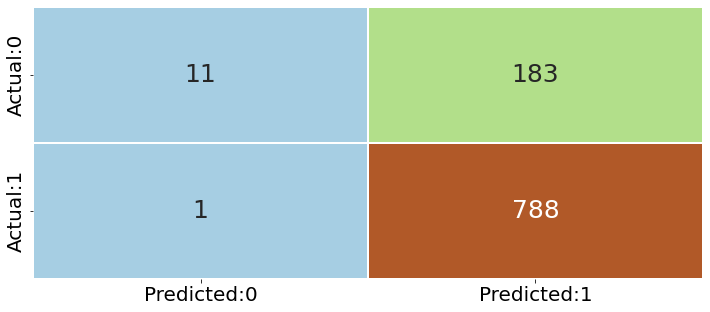

In [69]:
#defining the size of the canvas
plt.rcParams['figure.figsize'] = [12,5]
cm = confusion_matrix(y_test, y_pred_grid)
#confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
#plotting the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

### References

https://www.analyticsvidhya.com/blog/2021/05/natural-language-processing-step-by-step-guide/#h2_5

https://www.kaggle.com/code/halimedogan/sentiment-analysis-with-nlp-for-amazon-reviews/notebook#5.-Modeling

https://erleem.medium.com/nlp-complete-sentiment-analysis-on-amazon-reviews-374e4fea9976

https://towardsdatascience.com/sentiment-analysis-on-amazon-reviews-45cd169447ac